In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
import torch.utils.tensorboard

#writer = SummaryWriter()


In [2]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc21(h)
        log_var = self.fc22(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h))
        return x_recon

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var


In [3]:
def loss_function(x_recon, x, mu, log_var):
    # Reconstruction loss
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])


# Download MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
size_train_dataset  = len(train_dataset)

# Create a DataLoader
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [5]:



# Example usage
input_size = 784  # Size of the input data (e.g., for MNIST 28x28 images)
hidden_size = 256  # Size of the hidden layer
latent_size = 20  # Size of the latent space

vae = VAE(input_size, hidden_size, latent_size)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop (assuming you have a dataset called 'train_loader')

writer = SummaryWriter()
num_epochs = 15
for epoch in range(num_epochs):
    for batch_idx, data in enumerate(train_loader):
        x, _ = data
        x = x.view(-1, input_size)

        optimizer.zero_grad()
        x_recon, mu, log_var = vae(x)
        loss = loss_function(x_recon, x, mu, log_var)
        writer.add_scalar("Loss/train_batch", loss, epoch*(size_train_dataset//batch_size)+batch_idx)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print('Epoch {} [{}/{}]\tLoss: {:.3f}'.format(epoch, batch_idx, len(train_loader), loss.item()))
    writer.add_scalar("Loss/train_epoch", loss, epoch)




Epoch 0 [0/937]	Loss: 35147.062
Epoch 0 [200/937]	Loss: 10644.443
Epoch 0 [400/937]	Loss: 9280.508


KeyboardInterrupt: 

#### Reconstruction

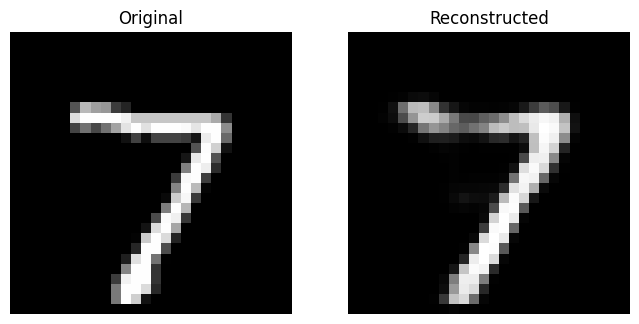

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Assuming you have a trained VAE model called 'vae'
vae.eval()  # Set the model to evaluation mode

# Download MNIST testing dataset
test_loader = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# Get a batch of data from the test_loader (or any other data loader)
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.view(-1, input_size)  # Flatten the input if needed

    # Forward pass through the VAE
    x_recon, _, _ = vae(x)

# Display the original and reconstructed images
def plot_images(original, reconstructed):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    axes[0].imshow(original[0].view(28, 28), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(reconstructed[0].view(28, 28), cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    plt.show()

plot_images(x, x_recon)


#### Génération

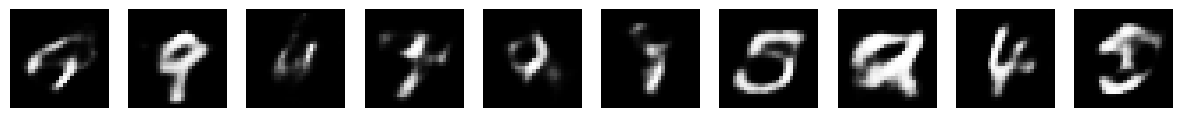

In [ ]:
# Generate new samples from the VAE
num_samples = 10
with torch.no_grad():
    z_samples = torch.randn(num_samples, latent_size)
    generated_samples = vae.decode(z_samples)

# Display the generated samples
def plot_generated_samples(samples):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        axes[i].imshow(samples[i].view(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.show()

plot_generated_samples(generated_samples)
